# Unstructured Data Analytics
## Assignment 2 - Beer Recommender

Submitted by

| Name   | UT EID |
| ------ | ---   |
| Mihir Deshpande | md46487 |
| Samarth Mishra | sm79247 |
| Muskan Agarwal | ma64547 |
| Sreekar Lanka | sl54387 |
| Rishabh Tiwari | rt27739 |

# First, we scrape the BeerAdvocate website -

### (Task A)

## Get links of the beer reviews we want to scrape -

In [1]:
import sys
from selenium.webdriver.common.by import By
from IPython.utils import text

import time

import selenium
from webdriver_manager.chrome import ChromeDriverManager

#WebDriver is a browser automation framework that works with open source APIs. 
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
#headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')

chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

driver = webdriver.Chrome(ChromeDriverManager().install(),options=chrome_options)



## Top Rated

url = 'https://www.beeradvocate.com/beer/top-rated/'
driver.get(url)
#lnks=driver.find_elements_by_tag_name("a")

pageelement= driver.find_elements(by=By.XPATH,value='/html/body/div[2]//td[@align="left" and @class="hr_bottom_light"]//a')

links=[]

for element in pageelement:
    link = element.get_attribute('href')
    links.append(link)
    #print(link)
    #print(values)

    
    


# Most Popular

url = 'https://www.beeradvocate.com/beer/popular/'
driver.get(url)
#lnks=driver.find_elements_by_tag_name("a")

pageelement= driver.find_elements(by=By.XPATH,value='/html/body/div[2]//td[@align="left" and @class="hr_bottom_light"]//a')


for element in pageelement:
    link = element.get_attribute('href')
    links.append(link)
    #print(link)
    #print(values)







# Most Famous

url = 'https://www.beeradvocate.com/beer/fame/'
driver.get(url)
#lnks=driver.find_elements_by_tag_name("a")

pageelement= driver.find_elements(by=By.XPATH,value='/html/body/div[2]//td[@align="left" and @class="hr_bottom_light"]//a')


for element in pageelement:
    link = element.get_attribute('href')
    links.append(link)
    #print(link)
    #print(values)


    
driver.quit()


links = links[::3]

links = list(set(links))

print("We are considering reviews from ",len(links)," beers.")






NameError: name 'webdriver' is not defined

## Now, let's scrape the website -

In [ ]:

driver = webdriver.Chrome(ChromeDriverManager().install(),options=chrome_options)

count = 0

reviews = []
for url in links:
    count = count+1
    print(count,"/",len(links))
    driver.get(url)
    # Get Product Name
    prod_name = driver.find_element(by=By.XPATH,value='/html/body/div[2]//div[@class="titleBar"]//h1').text.split("\n")[0]
    
    # Fetch page element
    pageelement= driver.find_elements(by=By.XPATH,value='/html/body/div[2]//div[@id="rating_fullview_content_2"]')
    
    # Get product name, user score and user review
    for element in pageelement:
        score = element.find_elements(By.CLASS_NAME, "BAscore_norm")
        if len(score) == 0:
            continue
        else:
            review = element.find_element(By.CSS_SELECTOR, "div[style='margin:10px 0px; padding:10px; border-left:2px solid #A9A9A9; font-size:11pt; line-height:1.4;']")
            reviews.append([prod_name,score[0].text, review.text])

driver.quit()


rev_pd = pd.DataFrame(reviews, columns=['prod_name','rating','user_review'])
rev_pd

## Exporting the scraped reviews in CSV -

In [2]:
rev_pd.to_csv('data/reviews_scraped.csv',index_label=False,index=False)

NameError: name 'rev_pd' is not defined

# Let's define all the required functions

In [24]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


def stem_lemm(word, lemmatize, stem):
    wnl = WordNetLemmatizer()
    ps = PorterStemmer()
    if lemmatize:
        word = wnl.lemmatize(word)
    if stem:
        word = ps.stem(word)
    return word



def pre_process(rev_pd):
    # Initialize corpus
    corpus = []
    corpus_lem_stem = []
    corpus_lem = []
    corpus_stem = []
    for i in range(0, len(rev_pd)):
        desc = re.sub('[\W]', ' ', str(rev_pd['user_review'][i]))
        desc = desc.lower()
        desc = desc.split()
        all_stopwords = stopwords.words('english')
        # Create WordNetLemmatizer object
        
        desc_lem_stem = [stem_lemm(word,True,True) for word in desc if not word in set(all_stopwords)]
        desc_lem = [stem_lemm(word,True,False) for word in desc if not word in set(all_stopwords)]
        desc_stem = [stem_lemm(word,False,True) for word in desc if not word in set(all_stopwords)]
        desc = [stem_lemm(word,False,False) for word in desc if not word in set(all_stopwords)]
        corpus.append(desc)
        corpus_lem_stem.append(desc_lem_stem)
        corpus_lem.append(desc_lem)
        corpus_stem.append(desc_stem)
    
    # Add corpus to dataframe
    review_list = []
    review_list_lem_stem = []
    review_list_lem = []
    review_list_stem = []
    
    for i in range(len(rev_pd)):
        review_list.append(' '.join(corpus[i]))
        review_list_lem_stem.append(' '.join(corpus_lem_stem[i]))
        review_list_lem.append(' '.join(corpus_lem[i]))
        review_list_stem.append(' '.join(corpus_stem[i]))

    rev_pd['review_list'] = review_list
    rev_pd['review_list_lem_stem'] = review_list_lem_stem
    rev_pd['review_list_lem'] = review_list_lem
    rev_pd['review_list_stem'] = review_list_stem
    
    return rev_pd

In [25]:
# Let's calculate the cosine similarity!

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from numpy.linalg import norm


def get_cosine(l1, l2):
    # cosine formula 
    cosine = np.dot(l1,l2)/(norm(l1)*norm(l2))
    return cosine

In [26]:
## Code for bag of words cosine similarity- 

def get_bow_cosine(attr, review):
    attr = [attr]
    review = [review]
    corp = attr.copy()
    corp.extend(review)
    cv = CountVectorizer(max_features = 5000)
    cv = cv.fit(corp)
    l1 = cv.transform(attr).toarray()
    l2 = cv.transform(review).toarray()
    return get_cosine(l1[0], l2[0])
    

In [27]:
import spacy

def get_spacy_similarity(attr, review, nlp):
    attr_spacy = nlp(attr)
    review_spacy = nlp(review)
    return review_spacy.similarity(attr_spacy)

In [28]:
# import SentimentIntensityAnalyzer class
# from vaderSentiment.vaderSentiment module.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
 
# function to print sentiments
# of the sentence.
def sentiment_scores(sentence,neg_weight=-1,neutral_weight=1,pos_weight=2):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    score = sentiment_dict['compound']
    #print("Score is - ", score)
    return score

In [29]:
# Function to calculate final score based on input attributes and give recommendations
def get_recommendations(df, input_attr, method='bow', lemmatize=True, stem=False, ratings=False, only_ratings=False):
    
    df_t = df.copy()
    
    #df_t = pre_process(df_t, lemmatize, stem)
    
    

    # Make sure you're processing the correct version of coirpus based on lemmatize and stem values
    if lemmatize:
        if stem:
            df_t['review_list'] = df_t['review_list_lem_stem'].copy()
        else:
            df_t['review_list'] = df_t['review_list_lem'].copy()
    elif stem:
        df_t['review_list'] = df_t['review_list_stem'].copy()
    
    # Calculate rating if only rating is True
    if only_ratings:
        df_t['score'] = df_t['rating']
        return df_t
    
    
    # Get similarity scores
    if method=='bow':
        df_t['similarity'] = df_t['review_list'].apply(lambda x: get_bow_cosine(input_attr, x))
    
    if method=='spacy':
        # Load required NLP model
        nlp = spacy.load("en_core_web_md")
        df_t['similarity'] = df_t['review_list'].apply(lambda x: get_spacy_similarity(input_attr, x, nlp))
    
    # Get Sentiment scores
    df_t['sentiment'] = df_t['user_review'].apply(lambda x: sentiment_scores(x))
    
    # Caclulate final score of review -
    
    if ratings:
        rat = df_t['rating']/5
        df_t['score'] = df_t['similarity']*df_t['sentiment']*rat
    else:
        df_t['score'] = df_t['similarity']*df_t['sentiment']
    
    return df_t

# Load and pre-process dataset -

In [30]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\smjoh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\smjoh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\smjoh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [33]:
import pandas as pd
import numpy as np

rev_pd = pd.read_csv("data/reviews_scraped.csv")

# For NLP -
import re

# First let's replace all new sentence characters with spaces
rev_pd['user_review'] = rev_pd['user_review'].apply(lambda x: re.sub('\n', ' ', x))
                                                    
# Let's pre-process the data and get relevant review_list columns

rev_pd = pre_process(rev_pd)


# Word Frequency Analysis -

### (Task B)

In [34]:
flatcorpus = []

# Let's look at the non-lemmatized non-stemmed version of the corpus -

for elem in rev_pd['review_list']:
    flatcorpus.extend(elem.split())


# Look at frequency plot -
freq_plot = pd.Series(flatcorpus).value_counts(ascending=False)
freq_plot.to_csv(r'data/my_review_freq.csv')

beer           5357
head           4554
taste          3726
dark           3043
light          2678
good           2653
like           2630
sweet          2530
medium         2424
malt           2396
nice           2381
carbonation    2304
chocolate      2264
notes          2249
one            2244
aroma          2180
finish         2155
bottle         2102
well           2042
white          1931
overall        1894
body           1843
pours          1814
flavor         1784
brown          1771
bit            1769
lacing         1758
coffee         1718
glass          1700
nose           1680
hops           1542
caramel        1514
mouthfeel      1497
color          1476
feel           1452
smooth         1436
smell          1425
bitterness     1418
great          1402
really         1381
orange         1380
black          1357
fruit          1356
little         1328
citrus         1315
bitter         1278
poured         1253
dry            1236
vanilla        1107
flavors        1103


<AxesSubplot:title={'center':'Frequency vs Rank'}, xlabel='Rank', ylabel='Frequency'>

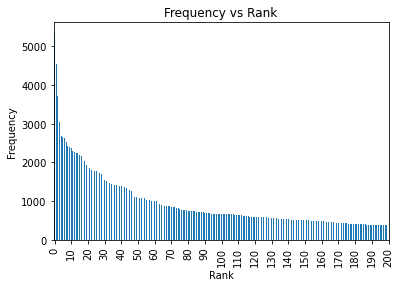

In [35]:
# Let's look at the top 20 words -
print(freq_plot[:50])

freq_plot[:200].plot(kind='bar',xticks=range(0,201,10),xlabel='Rank',ylabel='Frequency',title='Frequency vs Rank')

## We can pick out some of the following attributes -

	
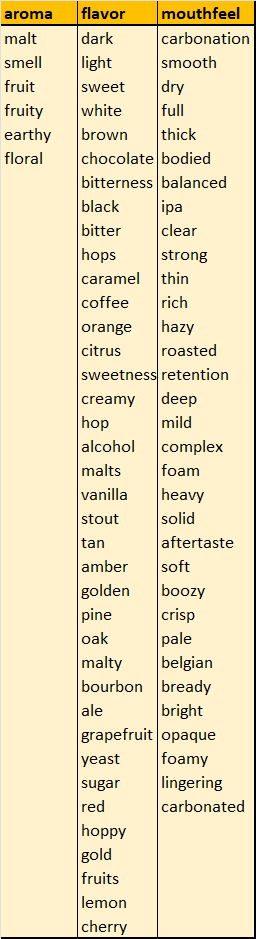

# Let's ask the user for input and give recommendations

### (Task C, Task D, Task E, Task F)

In [36]:
# Welcome!



print("Welcome to the beer recommendation genie!")
print("Please enter 3 attributes you want in your beer - \n")

wnl = WordNetLemmatizer()
ps = PorterStemmer()
inp = []
for i in range(3):
    inp.append(input("Input attribute - ").lower())


method=['bow','spacy']
    
    
# Lemmatize corpus
lemmatize = input("Do you want to lemmatize the reviews? (Y/N)\n")
if lemmatize == 'Y':
    lemmatize = True
    for i in range(3):
        inp[i] = wnl.lemmatize(inp[i])
elif lemmatize == 'N':
    lemmatize = False
else:
    print("Not sure what you entered, defaulting to Yes\n")
    lemmatize = True
    for i in range(3):
        inp[i] = wnl.lemmatize(inp[i])


# Stem corpus
stem = input("Do you want to stem the reviews? (Y/N)\n")
if stem == 'Y':
    stem = True
    for i in range(3):
        inp[i] = ps.stem(inp[i])
elif stem == 'N':
    stem = False
else:
    print("Not sure what you entered, defaulting to No\n")
    stem = False
    
    
# Convert input to sentence
inp = ' '.join(inp)

rev_pd_upd_bow = get_recommendations(rev_pd, inp, method='bow', lemmatize=lemmatize, stem=stem)
rev_pd_upd_spacy = get_recommendations(rev_pd, inp, method='spacy', lemmatize=lemmatize, stem=stem)




# Get top 3 recommendations

# From Bag of Words
rec_bow = rev_pd_upd_bow.groupby("prod_name").agg({'score':'mean', 'similarity':'mean', 'sentiment':'mean', 'rating':'mean'})
rec_spacy = rev_pd_upd_spacy.groupby("prod_name").agg({'score':'mean', 'similarity':'mean', 'sentiment':'mean', 'rating':'mean'})



print("Recommendations using Bag of Words are - \n", rec_bow.sort_values(by='score',ascending=False).iloc[:3,:])

print("\nRecommendations using spaCy are - \n", rec_spacy.sort_values(by='score',ascending=False).iloc[:3,:])

Welcome to the beer recommendation genie!
Please enter 3 attributes you want in your beer - 

Input attribute - light
Input attribute - malty
Input attribute - hazy
Do you want to lemmatize the reviews? (Y/N)
Y
Do you want to stem the reviews? (Y/N)
N


C:\Users\smjoh\AppData\Local\Temp\ipykernel_11288\3078254770.py:6: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return review_spacy.similarity(attr_spacy)


Recommendations using Bag of Words are - 
                       score  similarity  sentiment  rating
prod_name                                                 
Foggy Window       0.116166    0.152145   0.789650    4.50
Anchor Steam Beer  0.096010    0.114237   0.852815    3.89
Broo Doo           0.089658    0.099624   0.883370    4.21

Recommendations using spaCy are - 
                                              score  similarity  sentiment  \
prod_name                                                                   
Aurelian Lure                             0.744486    0.776558   0.958700   
Flora Plum                                0.703916    0.749181   0.937720   
Double Dry Hopped Double Mosaic Daydream  0.696801    0.751482   0.925725   

                                          rating  
prod_name                                         
Aurelian Lure                              4.390  
Flora Plum                                 4.694  
Double Dry Hopped Double Mosaic Day

## Which method worked better?

### (Task F)

In [37]:
# Let's check what percentage of reviews of the top 3 recommendations actually contained the attributes -



########################################## FOR Bag Of Words ###########################################################

rec_top = rec_bow.sort_values(by='score',ascending=False)

inp_vec = inp.split()

index = pd.MultiIndex.from_tuples([("Bag of Words", "First Recommendation"),
                                   ("Bag of Words", "Second Recommendation"),
                                   ("Bag of Words", "Third Recommendation"),
                                   ("spaCy", "First Recommendation"),
                                   ("spaCy", "Second Recommendation"),
                                   ("spaCy", "Third Recommendation"),])

count_df = pd.DataFrame(columns=['At least 1 attr(%)','At least 2 attr(%)','At least 3 attr(%)'],index=index)


## For recommendation 1 -
rev_pd_upd_iter = rev_pd_upd_bow[rev_pd_upd_bow['prod_name']==list(rec_top.index)[0]].reset_index()
count_1 = 0
count_2 = 0
count_3 = 0

for i in range(len(rev_pd_upd_iter)):
    count = 0
    if inp_vec[0] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[1] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[2] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    
    if count==1:
        count_1+=1
    elif count==2:
        count_1+=1
        count_2+=1
    elif count==3:
        count_1+=1
        count_2+=1
        count_3+=1


count_df.loc[("Bag of Words","First Recommendation"),"At least 1 attr(%)"] = np.round(count_1/len(rev_pd_upd_iter)*100, 2)
count_df.loc[("Bag of Words","First Recommendation"),"At least 2 attr(%)"] = np.round(count_2/len(rev_pd_upd_iter)*100, 2)
count_df.loc[("Bag of Words","First Recommendation"),"At least 3 attr(%)"] = np.round(count_3/len(rev_pd_upd_iter)*100, 2)


print("USING BAG OF WORDS - ")
print("For recommendation 1 - ")
print("% of reviews in which at least 1 attribute exists - ",(count_1/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which at least 2 attributes exist - ",(count_2/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which all 3 attributes exist - ",(count_3/len(rev_pd_upd_iter))*100, "%")



## For recommendation 2 -
rev_pd_upd_iter = rev_pd_upd_bow[rev_pd_upd_bow['prod_name']==list(rec_top.index)[1]].reset_index()
count_1 = 0
count_2 = 0
count_3 = 0

for i in range(len(rev_pd_upd_iter)):
    count = 0
    if inp_vec[0] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[1] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[2] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    
    if count==1:
        count_1+=1
    elif count==2:
        count_1+=1
        count_2+=1
    elif count==3:
        count_1+=1
        count_2+=1
        count_3+=1
        

count_df.loc[("Bag of Words","Second Recommendation"),"At least 1 attr(%)"] = np.round(count_1/len(rev_pd_upd_iter)*100, 2)
count_df.loc[("Bag of Words","Second Recommendation"),"At least 2 attr(%)"] = np.round(count_2/len(rev_pd_upd_iter)*100, 2)
count_df.loc[("Bag of Words","Second Recommendation"),"At least 3 attr(%)"] = np.round(count_3/len(rev_pd_upd_iter)*100, 2)


print("For recommendation 2 - ")
print("% of reviews in which at least 1 attribute exists - ",(count_1/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which at least 2 attributes exist - ",(count_2/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which all 3 attributes exist - ",(count_3/len(rev_pd_upd_iter))*100, "%")







## For recommendation 3 -
rev_pd_upd_iter = rev_pd_upd_bow[rev_pd_upd_bow['prod_name']==list(rec_top.index)[2]].reset_index()
count_1 = 0
count_2 = 0
count_3 = 0

for i in range(len(rev_pd_upd_iter)):
    count = 0
    if inp_vec[0] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[1] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[2] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    
    if count==1:
        count_1+=1
    elif count==2:
        count_1+=1
        count_2+=1
    elif count==3:
        count_1+=1
        count_2+=1
        count_3+=1



count_df.loc[("Bag of Words","Third Recommendation"),"At least 1 attr(%)"] = np.round(count_1/len(rev_pd_upd_iter)*100, 2)
count_df.loc[("Bag of Words","Third Recommendation"),"At least 2 attr(%)"] = np.round(count_2/len(rev_pd_upd_iter)*100, 2)
count_df.loc[("Bag of Words","Third Recommendation"),"At least 3 attr(%)"] = np.round(count_3/len(rev_pd_upd_iter)*100, 2)


print("For recommendation 3 - ")
print("% of reviews in which at least 1 attribute exists - ",(count_1/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which at least 2 attributes exist - ",(count_2/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which all 3 attributes exist - ",(count_3/len(rev_pd_upd_iter))*100, "%")







########################################## FOR spaCy (Word Embeddings) ###########################################################

rec_top = rec_spacy.sort_values(by='score',ascending=False)

inp_vec = inp.split()

## For recommendation 1 -
rev_pd_upd_iter = rev_pd_upd_spacy[rev_pd_upd_spacy['prod_name']==list(rec_top.index)[0]].reset_index()
count_1 = 0
count_2 = 0
count_3 = 0

for i in range(len(rev_pd_upd_iter)):
    count = 0
    if inp_vec[0] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[1] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[2] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    
    if count==1:
        count_1+=1
    elif count==2:
        count_1+=1
        count_2+=1
    elif count==3:
        count_1+=1
        count_2+=1
        count_3+=1


count_df.loc[("spaCy","First Recommendation"),"At least 1 attr(%)"] = np.round(count_1/len(rev_pd_upd_iter)*100, 2)
count_df.loc[("spaCy","First Recommendation"),"At least 2 attr(%)"] = np.round(count_2/len(rev_pd_upd_iter)*100, 2)
count_df.loc[("spaCy","First Recommendation"),"At least 3 attr(%)"] = np.round(count_3/len(rev_pd_upd_iter)*100, 2)


print("\n\n\nUSING spaCy (Word Embeddings) - ")
print("For recommendation 1 - ")
print("% of reviews in which at least 1 attribute exists - ",(count_1/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which at least 2 attributes exist - ",(count_2/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which all 3 attributes exist - ",(count_3/len(rev_pd_upd_iter))*100, "%")



## For recommendation 2 -
rev_pd_upd_iter = rev_pd_upd_spacy[rev_pd_upd_spacy['prod_name']==list(rec_top.index)[1]].reset_index()
count_1 = 0
count_2 = 0
count_3 = 0

for i in range(len(rev_pd_upd_iter)):
    count = 0
    if inp_vec[0] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[1] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[2] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    
    if count==1:
        count_1+=1
    elif count==2:
        count_1+=1
        count_2+=1
    elif count==3:
        count_1+=1
        count_2+=1
        count_3+=1
        

count_df.loc[("spaCy","Second Recommendation"),"At least 1 attr(%)"] = np.round(count_1/len(rev_pd_upd_iter)*100, 2)
count_df.loc[("spaCy","Second Recommendation"),"At least 2 attr(%)"] = np.round(count_2/len(rev_pd_upd_iter)*100, 2)
count_df.loc[("spaCy","Second Recommendation"),"At least 3 attr(%)"] = np.round(count_3/len(rev_pd_upd_iter)*100, 2)        
        
print("For recommendation 2 - ")
print("% of reviews in which at least 1 attribute exists - ",(count_1/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which at least 2 attributes exist - ",(count_2/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which all 3 attributes exist - ",(count_3/len(rev_pd_upd_iter))*100, "%")







## For recommendation 3 -
rev_pd_upd_iter = rev_pd_upd_spacy[rev_pd_upd_spacy['prod_name']==list(rec_top.index)[2]].reset_index()
count_1 = 0
count_2 = 0
count_3 = 0

for i in range(len(rev_pd_upd_iter)):
    count = 0
    if inp_vec[0] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[1] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[2] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    
    if count==1:
        count_1+=1
    elif count==2:
        count_1+=1
        count_2+=1
    elif count==3:
        count_1+=1
        count_2+=1
        count_3+=1
        
count_df.loc[("spaCy","Third Recommendation"),"At least 1 attr(%)"] = np.round(count_1/len(rev_pd_upd_iter)*100, 2)
count_df.loc[("spaCy","Third Recommendation"),"At least 2 attr(%)"] = np.round(count_2/len(rev_pd_upd_iter)*100, 2)
count_df.loc[("spaCy","Third Recommendation"),"At least 3 attr(%)"] = np.round(count_3/len(rev_pd_upd_iter)*100, 2)
        

print("For recommendation 3 - ")
print("% of reviews in which at least 1 attribute exists - ",(count_1/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which at least 2 attributes exist - ",(count_2/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which all 3 attributes exist - ",(count_3/len(rev_pd_upd_iter))*100, "%")




USING BAG OF WORDS - 
For recommendation 1 - 
% of reviews in which at least 1 attribute exists -  100.0 %
% of reviews in which at least 2 attributes exist -  50.0 %
% of reviews in which all 3 attributes exist -  0.0 %
For recommendation 2 - 
% of reviews in which at least 1 attribute exists -  84.61538461538461 %
% of reviews in which at least 2 attributes exist -  38.46153846153847 %
% of reviews in which all 3 attributes exist -  7.6923076923076925 %
For recommendation 3 - 
% of reviews in which at least 1 attribute exists -  100.0 %
% of reviews in which at least 2 attributes exist -  30.0 %
% of reviews in which all 3 attributes exist -  10.0 %



USING spaCy (Word Embeddings) - 
For recommendation 1 - 
% of reviews in which at least 1 attribute exists -  100.0 %
% of reviews in which at least 2 attributes exist -  0.0 %
% of reviews in which all 3 attributes exist -  0.0 %
For recommendation 2 - 
% of reviews in which at least 1 attribute exists -  80.0 %
% of reviews in which 

## Comparing the % of reviews of the recommendations in which at least 1, 2 and 3 attributes appear for Bag of Words and spaCy -

In [38]:
count_df

At least 1 attr(%) At least 2 attr(%)  \
Bag of Words First Recommendation               100.0               50.0   
             Second Recommendation              84.62              38.46   
             Third Recommendation               100.0               30.0   
spaCy        First Recommendation               100.0                0.0   
             Second Recommendation               80.0                0.0   
             Third Recommendation                75.0               50.0   

                                   At least 3 attr(%)  
Bag of Words First Recommendation                 0.0  
             Second Recommendation               7.69  
             Third Recommendation                10.0  
spaCy        First Recommendation                 0.0  
             Second Recommendation                0.0  
             Third Recommendation                 0.0

We see that through the Word vector approach (spacy), the recommendations have very less attribute matches with the attribute inputs a user has given. This is expected since a spacy word vector finds similarities between two statements based on their context rather than relying on exact attribute matches. The BoW approach on the other hand finds similarity on the basis of exact attribute matches.

## Let's see how our recommendations change when we also include rating in the score -

In [39]:
rev_pd_upd_bow_rat = get_recommendations(rev_pd, inp, method='bow', lemmatize=lemmatize, stem=stem, ratings=True)
rev_pd_upd_spacy_rat = get_recommendations(rev_pd, inp, method='spacy', lemmatize=lemmatize, stem=stem, ratings=True)

# Get top 3 recommendations

# From Bag of Words
rec_bow = rev_pd_upd_bow_rat.groupby("prod_name").agg({'score':'mean', 'similarity':'mean', 'sentiment':'mean', 'rating':'mean'})
rec_spacy = rev_pd_upd_spacy_rat.groupby("prod_name").agg({'score':'mean', 'similarity':'mean', 'sentiment':'mean', 'rating':'mean'})


print("Recommendations using Bag of Words are - \n", rec_bow.sort_values(by='score',ascending=False).iloc[:3,:])

print("\nRecommendations using spaCy are - \n", rec_spacy.sort_values(by='score',ascending=False).iloc[:3,:])

C:\Users\smjoh\AppData\Local\Temp\ipykernel_11288\3078254770.py:6: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return review_spacy.similarity(attr_spacy)


Recommendations using Bag of Words are - 
                  score  similarity  sentiment  rating
prod_name                                            
Foggy Window  0.104549    0.152145   0.789650   4.500
Ann           0.076452    0.095711   0.918625   4.505
Broo Doo      0.074448    0.099624   0.883370   4.210

Recommendations using spaCy are - 
                   score  similarity  sentiment  rating
prod_name                                             
Flora Plum     0.661847    0.749181   0.937720   4.694
Aurelian Lure  0.653659    0.776558   0.958700   4.390
Ann            0.621524    0.752550   0.918625   4.505


## How did the recommendations differ when we considered ratings as well?

In [40]:
# Specific code we want to hide:
# ==============================



# Let's check what percentage of reviews of the top 3 recommendations actually contained the attributes -



########################################## FOR Bag Of Words ###########################################################

rec_top = rec_bow.sort_values(by='score',ascending=False)

inp_vec = inp.split()

index = pd.MultiIndex.from_tuples([("Bag of Words", "First Recommendation"),
                                   ("Bag of Words", "Second Recommendation"),
                                   ("Bag of Words", "Third Recommendation"),
                                   ("spaCy", "First Recommendation"),
                                   ("spaCy", "Second Recommendation"),
                                   ("spaCy", "Third Recommendation"),])

count_df_2 = pd.DataFrame(columns=['At least 1 attr(%)','At least 2 attr(%)','At least 3 attr(%)'],index=index)


## For recommendation 1 -
rev_pd_upd_iter = rev_pd_upd_bow_rat[rev_pd_upd_bow_rat['prod_name']==list(rec_top.index)[0]].reset_index()
count_1 = 0
count_2 = 0
count_3 = 0

for i in range(len(rev_pd_upd_iter)):
    count = 0
    if inp_vec[0] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[1] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[2] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    
    if count==1:
        count_1+=1
    elif count==2:
        count_1+=1
        count_2+=1
    elif count==3:
        count_1+=1
        count_2+=1
        count_3+=1


count_df_2.loc[("Bag of Words","First Recommendation"),"At least 1 attr(%)"] = np.round(count_1/len(rev_pd_upd_iter)*100, 2)
count_df_2.loc[("Bag of Words","First Recommendation"),"At least 2 attr(%)"] = np.round(count_2/len(rev_pd_upd_iter)*100, 2)
count_df_2.loc[("Bag of Words","First Recommendation"),"At least 3 attr(%)"] = np.round(count_3/len(rev_pd_upd_iter)*100, 2)


print("USING BAG OF WORDS - ")
print("For recommendation 1 - ")
print("% of reviews in which at least 1 attribute exists - ",(count_1/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which at least 2 attributes exist - ",(count_2/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which all 3 attributes exist - ",(count_3/len(rev_pd_upd_iter))*100, "%")



## For recommendation 2 -
rev_pd_upd_iter = rev_pd_upd_bow_rat[rev_pd_upd_bow_rat['prod_name']==list(rec_top.index)[1]].reset_index()
count_1 = 0
count_2 = 0
count_3 = 0

for i in range(len(rev_pd_upd_iter)):
    count = 0
    if inp_vec[0] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[1] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[2] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    
    if count==1:
        count_1+=1
    elif count==2:
        count_1+=1
        count_2+=1
    elif count==3:
        count_1+=1
        count_2+=1
        count_3+=1
        

count_df_2.loc[("Bag of Words","Second Recommendation"),"At least 1 attr(%)"] = np.round(count_1/len(rev_pd_upd_iter)*100, 2)
count_df_2.loc[("Bag of Words","Second Recommendation"),"At least 2 attr(%)"] = np.round(count_2/len(rev_pd_upd_iter)*100, 2)
count_df_2.loc[("Bag of Words","Second Recommendation"),"At least 3 attr(%)"] = np.round(count_3/len(rev_pd_upd_iter)*100, 2)


print("For recommendation 2 - ")
print("% of reviews in which at least 1 attribute exists - ",(count_1/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which at least 2 attributes exist - ",(count_2/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which all 3 attributes exist - ",(count_3/len(rev_pd_upd_iter))*100, "%")







## For recommendation 3 -
rev_pd_upd_iter = rev_pd_upd_bow_rat[rev_pd_upd_bow_rat['prod_name']==list(rec_top.index)[2]].reset_index()
count_1 = 0
count_2 = 0
count_3 = 0

for i in range(len(rev_pd_upd_iter)):
    count = 0
    if inp_vec[0] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[1] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[2] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    
    if count==1:
        count_1+=1
    elif count==2:
        count_1+=1
        count_2+=1
    elif count==3:
        count_1+=1
        count_2+=1
        count_3+=1



count_df_2.loc[("Bag of Words","Third Recommendation"),"At least 1 attr(%)"] = np.round(count_1/len(rev_pd_upd_iter)*100, 2)
count_df_2.loc[("Bag of Words","Third Recommendation"),"At least 2 attr(%)"] = np.round(count_2/len(rev_pd_upd_iter)*100, 2)
count_df_2.loc[("Bag of Words","Third Recommendation"),"At least 3 attr(%)"] = np.round(count_3/len(rev_pd_upd_iter)*100, 2)


print("For recommendation 3 - ")
print("% of reviews in which at least 1 attribute exists - ",(count_1/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which at least 2 attributes exist - ",(count_2/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which all 3 attributes exist - ",(count_3/len(rev_pd_upd_iter))*100, "%")







########################################## FOR spaCy (Word Embeddings) ###########################################################

rec_top = rec_spacy.sort_values(by='score',ascending=False)

inp_vec = inp.split()

## For recommendation 1 -
rev_pd_upd_iter = rev_pd_upd_spacy_rat[rev_pd_upd_spacy_rat['prod_name']==list(rec_top.index)[0]].reset_index()
count_1 = 0
count_2 = 0
count_3 = 0

for i in range(len(rev_pd_upd_iter)):
    count = 0
    if inp_vec[0] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[1] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[2] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    
    if count==1:
        count_1+=1
    elif count==2:
        count_1+=1
        count_2+=1
    elif count==3:
        count_1+=1
        count_2+=1
        count_3+=1


count_df_2.loc[("spaCy","First Recommendation"),"At least 1 attr(%)"] = np.round(count_1/len(rev_pd_upd_iter)*100, 2)
count_df_2.loc[("spaCy","First Recommendation"),"At least 2 attr(%)"] = np.round(count_2/len(rev_pd_upd_iter)*100, 2)
count_df_2.loc[("spaCy","First Recommendation"),"At least 3 attr(%)"] = np.round(count_3/len(rev_pd_upd_iter)*100, 2)


print("\n\n\nUSING spaCy (Word Embeddings) - ")
print("For recommendation 1 - ")
print("% of reviews in which at least 1 attribute exists - ",(count_1/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which at least 2 attributes exist - ",(count_2/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which all 3 attributes exist - ",(count_3/len(rev_pd_upd_iter))*100, "%")



## For recommendation 2 -
rev_pd_upd_iter = rev_pd_upd_spacy_rat[rev_pd_upd_spacy_rat['prod_name']==list(rec_top.index)[1]].reset_index()
count_1 = 0
count_2 = 0
count_3 = 0

for i in range(len(rev_pd_upd_iter)):
    count = 0
    if inp_vec[0] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[1] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[2] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    
    if count==1:
        count_1+=1
    elif count==2:
        count_1+=1
        count_2+=1
    elif count==3:
        count_1+=1
        count_2+=1
        count_3+=1
        

count_df_2.loc[("spaCy","Second Recommendation"),"At least 1 attr(%)"] = np.round(count_1/len(rev_pd_upd_iter)*100, 2)
count_df_2.loc[("spaCy","Second Recommendation"),"At least 2 attr(%)"] = np.round(count_2/len(rev_pd_upd_iter)*100, 2)
count_df_2.loc[("spaCy","Second Recommendation"),"At least 3 attr(%)"] = np.round(count_3/len(rev_pd_upd_iter)*100, 2)        
        
print("For recommendation 2 - ")
print("% of reviews in which at least 1 attribute exists - ",(count_1/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which at least 2 attributes exist - ",(count_2/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which all 3 attributes exist - ",(count_3/len(rev_pd_upd_iter))*100, "%")







## For recommendation 3 -
rev_pd_upd_iter = rev_pd_upd_spacy_rat[rev_pd_upd_spacy_rat['prod_name']==list(rec_top.index)[2]].reset_index()
count_1 = 0
count_2 = 0
count_3 = 0

for i in range(len(rev_pd_upd_iter)):
    count = 0
    if inp_vec[0] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[1] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[2] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    
    if count==1:
        count_1+=1
    elif count==2:
        count_1+=1
        count_2+=1
    elif count==3:
        count_1+=1
        count_2+=1
        count_3+=1
        
count_df_2.loc[("spaCy","Third Recommendation"),"At least 1 attr(%)"] = np.round(count_1/len(rev_pd_upd_iter)*100, 2)
count_df_2.loc[("spaCy","Third Recommendation"),"At least 2 attr(%)"] = np.round(count_2/len(rev_pd_upd_iter)*100, 2)
count_df_2.loc[("spaCy","Third Recommendation"),"At least 3 attr(%)"] = np.round(count_3/len(rev_pd_upd_iter)*100, 2)
        

print("For recommendation 3 - ")
print("% of reviews in which at least 1 attribute exists - ",(count_1/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which at least 2 attributes exist - ",(count_2/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which all 3 attributes exist - ",(count_3/len(rev_pd_upd_iter))*100, "%")


# @hidden
from IPython.display import HTML
password="xxxxx"
# ==============================

# Necessary script to hide the cell:
# ==============================
HTML('''<script>
  code_show=true; 
  function code_toggle() {
    if (code_show){
        $('.cm-comment:contains(@hidden)').closest('div.input').hide();
    } else {
        $('.cm-comment:contains(@hidden)').closest('div.input').show();
    }
    code_show = !code_show
  } 
  $( document ).ready(code_toggle);
</script>
To show the code hidden: click <a href="javascript:code_toggle()">here</a>.''')
# ==============================



USING BAG OF WORDS - 
For recommendation 1 - 
% of reviews in which at least 1 attribute exists -  100.0 %
% of reviews in which at least 2 attributes exist -  50.0 %
% of reviews in which all 3 attributes exist -  0.0 %
For recommendation 2 - 
% of reviews in which at least 1 attribute exists -  75.0 %
% of reviews in which at least 2 attributes exist -  0.0 %
% of reviews in which all 3 attributes exist -  0.0 %
For recommendation 3 - 
% of reviews in which at least 1 attribute exists -  100.0 %
% of reviews in which at least 2 attributes exist -  30.0 %
% of reviews in which all 3 attributes exist -  10.0 %



USING spaCy (Word Embeddings) - 
For recommendation 1 - 
% of reviews in which at least 1 attribute exists -  80.0 %
% of reviews in which at least 2 attributes exist -  0.0 %
% of reviews in which all 3 attributes exist -  0.0 %
For recommendation 2 - 
% of reviews in which at least 1 attribute exists -  100.0 %
% of reviews in which at least 2 attributes exist -  0.0 %
% of 

## Now let's see if we suggest based ONLY on ratings, how do our recommendations change-

In [41]:
rev_pd_upd_bow_only_rat = get_recommendations(rev_pd, inp, method='bow', lemmatize=lemmatize, stem=stem, only_ratings=True)
rev_pd_upd_spacy_only_rat = get_recommendations(rev_pd, inp, method='spacy', lemmatize=lemmatize, stem=stem, only_ratings=True)

# Get top 3 recommendations

# From Bag of Words
rec_bow = rev_pd_upd_bow_only_rat.groupby("prod_name").agg({'score':'mean', 'rating':'mean'})
rec_spacy = rev_pd_upd_spacy_only_rat.groupby("prod_name").agg({'score':'mean', 'rating':'mean'})


print("Recommendations using Bag of Words are - \n", rec_bow.sort_values(by='score',ascending=False).iloc[:3,:])

print("\nRecommendations using spaCy are - \n", rec_spacy.sort_values(by='score',ascending=False).iloc[:3,:])

Recommendations using Bag of Words are - 
                                             score    rating
prod_name                                                  
The Adjunct Trail - Bourbon Barrel-Aged  4.930000  4.930000
Twice the Daily Serving: Raspberry       4.833333  4.833333
Art                                      4.810000  4.810000

Recommendations using spaCy are - 
                                             score    rating
prod_name                                                  
The Adjunct Trail - Bourbon Barrel-Aged  4.930000  4.930000
Twice the Daily Serving: Raspberry       4.833333  4.833333
Art                                      4.810000  4.810000


### Let's check what percentage of reviews of the top 3 recommendations actually contained the attributes -

In [42]:
# Specific code we want to hide:
# ==============================


# Let's check what percentage of reviews of the top 3 recommendations actually contained the attributes -



########################################## FOR Bag Of Words ###########################################################

rec_top = rec_bow.sort_values(by='score',ascending=False)

inp_vec = inp.split()

index = pd.MultiIndex.from_tuples([("Bag of Words", "First Recommendation"),
                                   ("Bag of Words", "Second Recommendation"),
                                   ("Bag of Words", "Third Recommendation"),
                                   ("spaCy", "First Recommendation"),
                                   ("spaCy", "Second Recommendation"),
                                   ("spaCy", "Third Recommendation"),])

count_df_3 = pd.DataFrame(columns=['At least 1 attr(%)','At least 2 attr(%)','At least 3 attr(%)'],index=index)


## For recommendation 1 -
rev_pd_upd_iter = rev_pd_upd_bow_only_rat[rev_pd_upd_bow_only_rat['prod_name']==list(rec_top.index)[0]].reset_index()
count_1 = 0
count_2 = 0
count_3 = 0

for i in range(len(rev_pd_upd_iter)):
    count = 0
    if inp_vec[0] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[1] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[2] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    
    if count==1:
        count_1+=1
    elif count==2:
        count_1+=1
        count_2+=1
    elif count==3:
        count_1+=1
        count_2+=1
        count_3+=1


count_df_3.loc[("Bag of Words","First Recommendation"),"At least 1 attr(%)"] = np.round(count_1/len(rev_pd_upd_iter)*100, 2)
count_df_3.loc[("Bag of Words","First Recommendation"),"At least 2 attr(%)"] = np.round(count_2/len(rev_pd_upd_iter)*100, 2)
count_df_3.loc[("Bag of Words","First Recommendation"),"At least 3 attr(%)"] = np.round(count_3/len(rev_pd_upd_iter)*100, 2)


print("USING BAG OF WORDS - ")
print("For recommendation 1 - ")
print("% of reviews in which at least 1 attribute exists - ",(count_1/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which at least 2 attributes exist - ",(count_2/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which all 3 attributes exist - ",(count_3/len(rev_pd_upd_iter))*100, "%")



## For recommendation 2 -
rev_pd_upd_iter = rev_pd_upd_bow_only_rat[rev_pd_upd_bow_only_rat['prod_name']==list(rec_top.index)[1]].reset_index()
count_1 = 0
count_2 = 0
count_3 = 0

for i in range(len(rev_pd_upd_iter)):
    count = 0
    if inp_vec[0] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[1] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[2] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    
    if count==1:
        count_1+=1
    elif count==2:
        count_1+=1
        count_2+=1
    elif count==3:
        count_1+=1
        count_2+=1
        count_3+=1
        

count_df_3.loc[("Bag of Words","Second Recommendation"),"At least 1 attr(%)"] = np.round(count_1/len(rev_pd_upd_iter)*100, 2)
count_df_3.loc[("Bag of Words","Second Recommendation"),"At least 2 attr(%)"] = np.round(count_2/len(rev_pd_upd_iter)*100, 2)
count_df_3.loc[("Bag of Words","Second Recommendation"),"At least 3 attr(%)"] = np.round(count_3/len(rev_pd_upd_iter)*100, 2)


print("For recommendation 2 - ")
print("% of reviews in which at least 1 attribute exists - ",(count_1/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which at least 2 attributes exist - ",(count_2/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which all 3 attributes exist - ",(count_3/len(rev_pd_upd_iter))*100, "%")







## For recommendation 3 -
rev_pd_upd_iter = rev_pd_upd_bow_only_rat[rev_pd_upd_bow_only_rat['prod_name']==list(rec_top.index)[2]].reset_index()
count_1 = 0
count_2 = 0
count_3 = 0

for i in range(len(rev_pd_upd_iter)):
    count = 0
    if inp_vec[0] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[1] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[2] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    
    if count==1:
        count_1+=1
    elif count==2:
        count_1+=1
        count_2+=1
    elif count==3:
        count_1+=1
        count_2+=1
        count_3+=1



count_df_3.loc[("Bag of Words","Third Recommendation"),"At least 1 attr(%)"] = np.round(count_1/len(rev_pd_upd_iter)*100, 2)
count_df_3.loc[("Bag of Words","Third Recommendation"),"At least 2 attr(%)"] = np.round(count_2/len(rev_pd_upd_iter)*100, 2)
count_df_3.loc[("Bag of Words","Third Recommendation"),"At least 3 attr(%)"] = np.round(count_3/len(rev_pd_upd_iter)*100, 2)


print("For recommendation 3 - ")
print("% of reviews in which at least 1 attribute exists - ",(count_1/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which at least 2 attributes exist - ",(count_2/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which all 3 attributes exist - ",(count_3/len(rev_pd_upd_iter))*100, "%")







########################################## FOR spaCy (Word Embeddings) ###########################################################

rec_top = rec_spacy.sort_values(by='score',ascending=False)

inp_vec = inp.split()

## For recommendation 1 -
rev_pd_upd_iter = rev_pd_upd_spacy_only_rat[rev_pd_upd_spacy_only_rat['prod_name']==list(rec_top.index)[0]].reset_index()
count_1 = 0
count_2 = 0
count_3 = 0

for i in range(len(rev_pd_upd_iter)):
    count = 0
    if inp_vec[0] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[1] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[2] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    
    if count==1:
        count_1+=1
    elif count==2:
        count_1+=1
        count_2+=1
    elif count==3:
        count_1+=1
        count_2+=1
        count_3+=1


count_df_3.loc[("spaCy","First Recommendation"),"At least 1 attr(%)"] = np.round(count_1/len(rev_pd_upd_iter)*100, 2)
count_df_3.loc[("spaCy","First Recommendation"),"At least 2 attr(%)"] = np.round(count_2/len(rev_pd_upd_iter)*100, 2)
count_df_3.loc[("spaCy","First Recommendation"),"At least 3 attr(%)"] = np.round(count_3/len(rev_pd_upd_iter)*100, 2)


print("USING spaCy (Word Embeddings) - ")
print("For recommendation 1 - ")
print("% of reviews in which at least 1 attribute exists - ",(count_1/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which at least 2 attributes exist - ",(count_2/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which all 3 attributes exist - ",(count_3/len(rev_pd_upd_iter))*100, "%")



## For recommendation 2 -
rev_pd_upd_iter = rev_pd_upd_spacy_only_rat[rev_pd_upd_spacy_only_rat['prod_name']==list(rec_top.index)[1]].reset_index()
count_1 = 0
count_2 = 0
count_3 = 0

for i in range(len(rev_pd_upd_iter)):
    count = 0
    if inp_vec[0] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[1] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[2] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    
    if count==1:
        count_1+=1
    elif count==2:
        count_1+=1
        count_2+=1
    elif count==3:
        count_1+=1
        count_2+=1
        count_3+=1
        

count_df_3.loc[("spaCy","Second Recommendation"),"At least 1 attr(%)"] = np.round(count_1/len(rev_pd_upd_iter)*100, 2)
count_df_3.loc[("spaCy","Second Recommendation"),"At least 2 attr(%)"] = np.round(count_2/len(rev_pd_upd_iter)*100, 2)
count_df_3.loc[("spaCy","Second Recommendation"),"At least 3 attr(%)"] = np.round(count_3/len(rev_pd_upd_iter)*100, 2)        
        
print("For recommendation 2 - ")
print("% of reviews in which at least 1 attribute exists - ",(count_1/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which at least 2 attributes exist - ",(count_2/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which all 3 attributes exist - ",(count_3/len(rev_pd_upd_iter))*100, "%")







## For recommendation 3 -
rev_pd_upd_iter = rev_pd_upd_spacy_only_rat[rev_pd_upd_spacy_only_rat['prod_name']==list(rec_top.index)[2]].reset_index()
count_1 = 0
count_2 = 0
count_3 = 0

for i in range(len(rev_pd_upd_iter)):
    count = 0
    if inp_vec[0] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[1] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    if inp_vec[2] in rev_pd_upd_iter['review_list'][i]:
        count+=1
    
    if count==1:
        count_1+=1
    elif count==2:
        count_1+=1
        count_2+=1
    elif count==3:
        count_1+=1
        count_2+=1
        count_3+=1
        
count_df_3.loc[("spaCy","Third Recommendation"),"At least 1 attr(%)"] = np.round(count_1/len(rev_pd_upd_iter)*100, 2)
count_df_3.loc[("spaCy","Third Recommendation"),"At least 2 attr(%)"] = np.round(count_2/len(rev_pd_upd_iter)*100, 2)
count_df_3.loc[("spaCy","Third Recommendation"),"At least 3 attr(%)"] = np.round(count_3/len(rev_pd_upd_iter)*100, 2)
        

print("For recommendation 3 - ")
print("% of reviews in which at least 1 attribute exists - ",(count_1/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which at least 2 attributes exist - ",(count_2/len(rev_pd_upd_iter))*100, "%")
print("% of reviews in which all 3 attributes exist - ",(count_3/len(rev_pd_upd_iter))*100, "%")

# @hidden
from IPython.display import HTML
password="xxxxx"
# ==============================

# Necessary script to hide the cell:
# ==============================
HTML('''<script>
  code_show=true; 
  function code_toggle() {
    if (code_show){
        $('.cm-comment:contains(@hidden)').closest('div.input').hide();
    } else {
        $('.cm-comment:contains(@hidden)').closest('div.input').show();
    }
    code_show = !code_show
  } 
  $( document ).ready(code_toggle);
</script>
To show the code hidden: click <a href="javascript:code_toggle()">here</a>.''')
# ==============================



USING BAG OF WORDS - 
For recommendation 1 - 
% of reviews in which at least 1 attribute exists -  0.0 %
% of reviews in which at least 2 attributes exist -  0.0 %
% of reviews in which all 3 attributes exist -  0.0 %
For recommendation 2 - 
% of reviews in which at least 1 attribute exists -  16.666666666666664 %
% of reviews in which at least 2 attributes exist -  16.666666666666664 %
% of reviews in which all 3 attributes exist -  0.0 %
For recommendation 3 - 
% of reviews in which at least 1 attribute exists -  0.0 %
% of reviews in which at least 2 attributes exist -  0.0 %
% of reviews in which all 3 attributes exist -  0.0 %
USING spaCy (Word Embeddings) - 
For recommendation 1 - 
% of reviews in which at least 1 attribute exists -  0.0 %
% of reviews in which at least 2 attributes exist -  0.0 %
% of reviews in which all 3 attributes exist -  0.0 %
For recommendation 2 - 
% of reviews in which at least 1 attribute exists -  16.666666666666664 %
% of reviews in which at least 2 

## Let's see how the % change -

In [43]:
# With Sentiment, similarity -
count_df

At least 1 attr(%) At least 2 attr(%)  \
Bag of Words First Recommendation               100.0               50.0   
             Second Recommendation              84.62              38.46   
             Third Recommendation               100.0               30.0   
spaCy        First Recommendation               100.0                0.0   
             Second Recommendation               80.0                0.0   
             Third Recommendation                75.0               50.0   

                                   At least 3 attr(%)  
Bag of Words First Recommendation                 0.0  
             Second Recommendation               7.69  
             Third Recommendation                10.0  
spaCy        First Recommendation                 0.0  
             Second Recommendation                0.0  
             Third Recommendation                 0.0

In [44]:
# With sentiment, similarity and Ratings -
count_df_2

At least 1 attr(%) At least 2 attr(%)  \
Bag of Words First Recommendation               100.0               50.0   
             Second Recommendation               75.0                0.0   
             Third Recommendation               100.0               30.0   
spaCy        First Recommendation                80.0                0.0   
             Second Recommendation              100.0                0.0   
             Third Recommendation                75.0                0.0   

                                   At least 3 attr(%)  
Bag of Words First Recommendation                 0.0  
             Second Recommendation                0.0  
             Third Recommendation                10.0  
spaCy        First Recommendation                 0.0  
             Second Recommendation                0.0  
             Third Recommendation                 0.0

In [45]:
# With Ratings ONLY -
count_df_3_temp = count_df_3[:3].copy()
count_df_3_temp.index = ["First Recommendation", "Second Recommendation", "Third Recommendation"]
count_df_3_temp

,At least 1 attr(%),At least 2 attr(%),At least 3 attr(%)
First Recommendation,0.0,0.0,0.0
Second Recommendation,16.67,16.67,0.0
Third Recommendation,0.0,0.0,0.0


## Insights -

When we ignore the similarity and feature sentiment, we’re not able to recommend based on the attributes. We’ll be simply recommending the top-rated beers and that’ll be a very generic list. The products mentioned in the recommendations would not meet the requirements what the user was looking for because it’s a very generic list.

We can see from the above tables that the recommendations made when only ratings are considered are generally terrible (the attributes entered by the user are more or less absent in the recommendations unless they exist by co-incidence).

But when we include ratings alongwith similarity and sensitivity in the final score of the recommendation system, it basically offsets any errors made by the sentiment analyzer. For instance, if the review states “this beer is too sweet”. The reviewer might have said this in a negative connotation but that’s not captured correctly by the sentiment analyzer. So, for this the reviewer would have not rated it very high. So, when we include the ratings in the final score it makes our recommendation system more robust.

# Let's caclulate lift! 

### (Task H)

### First by defining a function 

In [46]:
# Creating a function to caclulate lift

def calc_lift_dissimilarity(corpus,df,mat_a,mat_b,mat_a_freq,mat_b_freq,diss=False):

    for sent in range(0,len(corpus)):
        for i in range(0,len(df)):
            if mat_a[i] in corpus[sent]:
                #print(i)
                for j in range(0,len(df.columns)):
                    if mat_b[j] in corpus[sent]:
                        #print(top10[j])
                        df.iloc[i][j]+=1
    # We calculate Lift by the following formula - 
    # Lift (A,B) = [N*#(A,B)] / [#(A)*#(B)]
    
    N = len(corpus)
    for i in range(0,len(mat_a)):
        for j in range(0,len(mat_b)):
            #df.iloc[i,j] = (N*df.iloc[i,j])/(top10_freq[top10[i]]*top10_freq[top10[j]])
            num = N*df.iloc[i,j]
            #print(mat_a[i])
            #print(type(mat_a[i]))
            denom = mat_a_freq[mat_a[i]]*mat_b_freq[mat_b[j]]
            if num==0:
                df.iloc[i,j] = 0
            elif diss:
                df.iloc[i,j] = denom/num
            else:
                df.iloc[i,j] = num/denom
    return df

# Let's look at LIFT values

In order to calculate lift values, we first append the names of the products to the reviews as a single string and then take value counts of the beer product names and corresponding attributes using this updated string.

In [47]:
# Let's first create a column that we can use to analyze lift values -
prod_name_upd = rev_pd['prod_name'].apply(lambda x: '_'.join(x.split()))
rev_pd['review_list_prod'] = prod_name_upd + " " + rev_pd['review_list']

In [48]:
flatcorpus_upd = []

# Let's look at the lemmatized non-stemmed version of the corpus with product names -

corpus_upd = []
for elem in rev_pd['review_list_prod']:
    flatcorpus_upd.extend(elem.split())
    corpus_upd.append(elem.split())


# Look at frequency plot -
freq_plot_upd = pd.Series(flatcorpus_upd).value_counts(ascending=False)

# Let's look at the top 10 beers -

top = []
top_val = []

for ind, row in freq_plot_upd.iteritems():
    if ind in list(prod_name_upd):
        top.append(ind)
        top_val.append(row)

top10 = top[0:10]
top10_val = top_val[0:10]

In [49]:
# Get frequencies of individual products
top10_freq ={}
for i in range(0,len(top10)):
    top10_freq[top10[i]] = top10_val[i]

top10_freq

{'IPA': 96,
 'Tripel': 43,
 'Imperial_Stout': 39,
 'Porter': 37,
 'Pliny_The_Elder': 30,
 'Storm_King': 28,
 'Vintage_Ale': 24,
 'Perpetual_IPA': 24,
 'Trappist_Westvleteren_12_(XII)': 23,
 'Special_Double_Cream_Stout': 23}

In [50]:
# Looking at the word frequency sheet, let's note down a few attributes -

attributes = ['malt','fruit','light','smooth','dark','full','carbonation']

In [51]:
# Let's calculate attribute frequencies -


attr_freq = {}

for ind, row in freq_plot_upd.iteritems():
    if ind in attributes:
        
        attr_freq[ind] = row

attr_freq

{'dark': 3043,
 'light': 2678,
 'malt': 2396,
 'carbonation': 2304,
 'smooth': 1436,
 'fruit': 1356,
 'full': 1088}

In [52]:
# Let's calculate lift between the top 10 beer products and these attributes to see 
# which attributes are strongly related to which products
zero_data = np.zeros(shape=(len(attributes),len(top10)))
lift_attr_df = pd.DataFrame(zero_data)
lift_attr_df.columns = top10
lift_attr_df.index = attributes

In [53]:
lift_attr_df = calc_lift_dissimilarity(corpus_upd,lift_attr_df,attributes,top10,attr_freq,top10_freq)

threshold = 1.0

for i in range(0,len(lift_attr_df)):
    for j in range (0,len(lift_attr_df.columns)):
        if lift_attr_df.iloc[i][j]<=threshold:
            lift_attr_df.iloc[i][j] = 0

lift_attr_df

,IPA,Tripel,Imperial_Stout,Porter,Pliny_The_Elder,Storm_King,Vintage_Ale,Perpetual_IPA,Trappist_Westvleteren_12_(XII),Special_Double_Cream_Stout
malt,0.0,0.000000,0.000000,1.081916,0.000000,1.209725,0.000000,1.154737,0.000000,0.000000
fruit,0.0,1.518419,0.000000,0.000000,0.000000,0.000000,1.360251,0.000000,1.419392,0.000000
light,0.0,0.000000,0.000000,1.191369,0.000000,0.000000,1.147934,0.000000,0.000000,0.000000
smooth,0.0,2.509199,1.844368,1.249755,0.000000,0.000000,1.284471,0.000000,0.000000,1.787090
dark,0.0,0.000000,1.554219,1.310584,0.000000,1.212291,0.000000,0.000000,1.054166,1.159582
full,0.0,0.000000,1.912660,0.000000,0.000000,1.937500,1.412760,0.000000,2.063859,0.000000
carbonation,0.0,1.042595,1.231637,1.298212,1.067419,1.029297,1.467701,0.000000,1.113829,0.000000


# Insights - 

We are considering those beers to be similar who have at least three attributes matching with another beer on the basis of lift values (Lift value > 1). 

1. Storm King, Imperial Stout and Trappist Westvleteren 12 (XII) have three common stated attributes from the list ('Smooth', 'Dark', 'Full' and 'Carbonation'). These look to be the most similar set among the beers we have considered and could be recommended to users drinking one of these
2. Porter, Storm King and Vintage Ale also appear to be very similar in terms of attribute similarity among the beers
3. We see that the beers Imperial Stout and Porter have strong lift values with 'Smooth', 'Dark' and 'Carbonation'. These are most similar to each other and users drinking one of these could be recommended the other drink
4. Storm King appears to be the brand which is similar to most of the beers we have considered (having attribute similarity with Imperial Stout, Trappist Westvleteren 12 (XII), Porter and Vintage Ale)